In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import cv2
import glob as gb
import pandas as pd
import seaborn as sns
import matplotlib.image as mpimg
import imagehash
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.applications import VGG16
from keras.applications import ResNet101

from keras.applications import EfficientNetB0
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling2D
from keras.optimizers import Adam

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
train_path = '/kaggle/input/terrain-recognition/Data Main/train'
test_path = '/kaggle/input/terrain-recognition/Data Main/test'


In [3]:
from keras.preprocessing.image import ImageDataGenerator
# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1.0/255,                # Rescale pixel values to [0, 1]
    rotation_range=20,              # Random rotation within 20 degrees
    width_shift_range=0.2,          # Random horizontal shift by 20% of image width
    height_shift_range=0.2,         # Random vertical shift by 20% of image height
    horizontal_flip=True,           # Random horizontal flipping
    fill_mode='nearest'             # Fill mode for new pixels after shifts/rotations
)

In [4]:
size_images = 150
batch_size = 32

In [5]:
train_generator = train_datagen.flow_from_directory(
    train_path,                     # Path to the training data
    target_size=(size_images, size_images),  # Resize images to this size
    batch_size = batch_size,        # Number of images in each batch
    class_mode ='categorical'       # Mode for class labels (categorical for one-hot encoding)
)

Found 31571 images belonging to 4 classes.


In [6]:
labels_count = train_generator.classes

In [7]:
print(labels_count)


[0 0 0 ... 3 3 3]


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


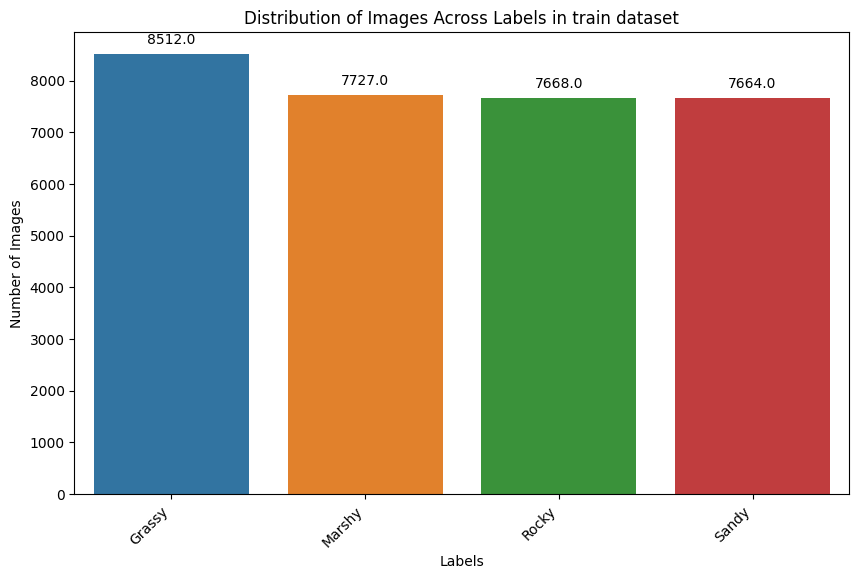

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'train_generator' is your image data generator
labels_count = train_generator.classes
class_names = list(train_generator.class_indices.keys())

plt.figure(figsize=(10, 6))
ax = sns.countplot(x=labels_count)
plt.title('Distribution of Images Across Labels in train dataset')
plt.xlabel('Labels')
plt.ylabel('Number of Images')

# Add the count on top of each bar
for i, p in enumerate(ax.patches):
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Add class names below the bars
ax.set_xticklabels(class_names, rotation=45, ha='right')

plt.show()


In [9]:
test_datagen = ImageDataGenerator(rescale=1.0/255)


In [10]:
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(size_images, size_images),
    batch_size = batch_size,
    class_mode='categorical')

Found 6769 images belonging to 4 classes.


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


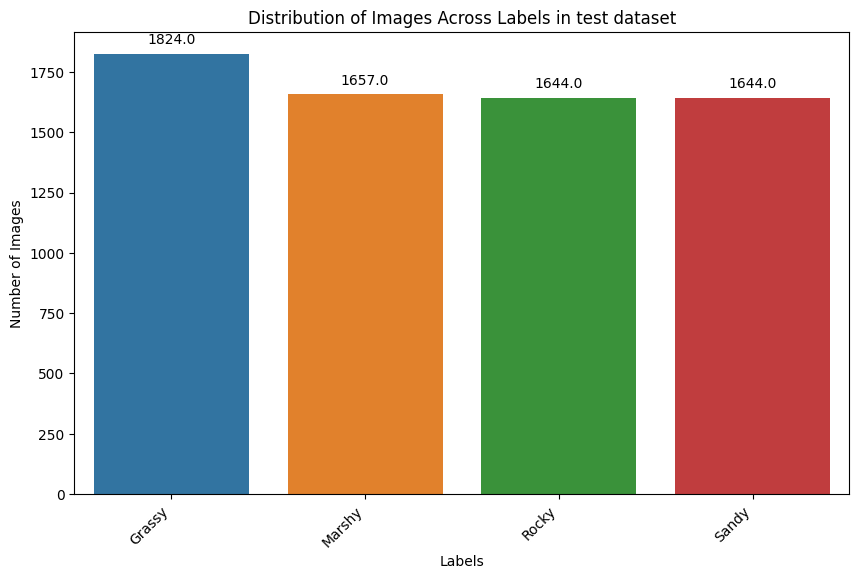

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'train_generator' is your image data generator
labels_count = test_generator.classes
class_names = list(test_generator.class_indices.keys())

plt.figure(figsize=(10, 6))
ax = sns.countplot(x=labels_count)
plt.title('Distribution of Images Across Labels in test dataset')
plt.xlabel('Labels')
plt.ylabel('Number of Images')

# Add the count on top of each bar
for i, p in enumerate(ax.patches):
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Add class names below the bars
ax.set_xticklabels(class_names, rotation=45, ha='right')

plt.show()


In [12]:
def Show_Images(target_gen):
    # Get a batch of images and labels
    batch_images, batch_labels = next(target_gen)

    # Get class labels
    class_labels = list(target_gen.class_indices.keys())

    # Display images with labels
    plt.figure(figsize=(20, 20))
    for n , i in enumerate(list(np.random.randint(0,len(batch_images),36))):
        plt.subplot(6, 6, n + 1)
        plt.imshow(batch_images[i])
        plt.title(class_labels[np.argmax(batch_labels[i])])  # Display the class label
        plt.axis('off')
    plt.show()

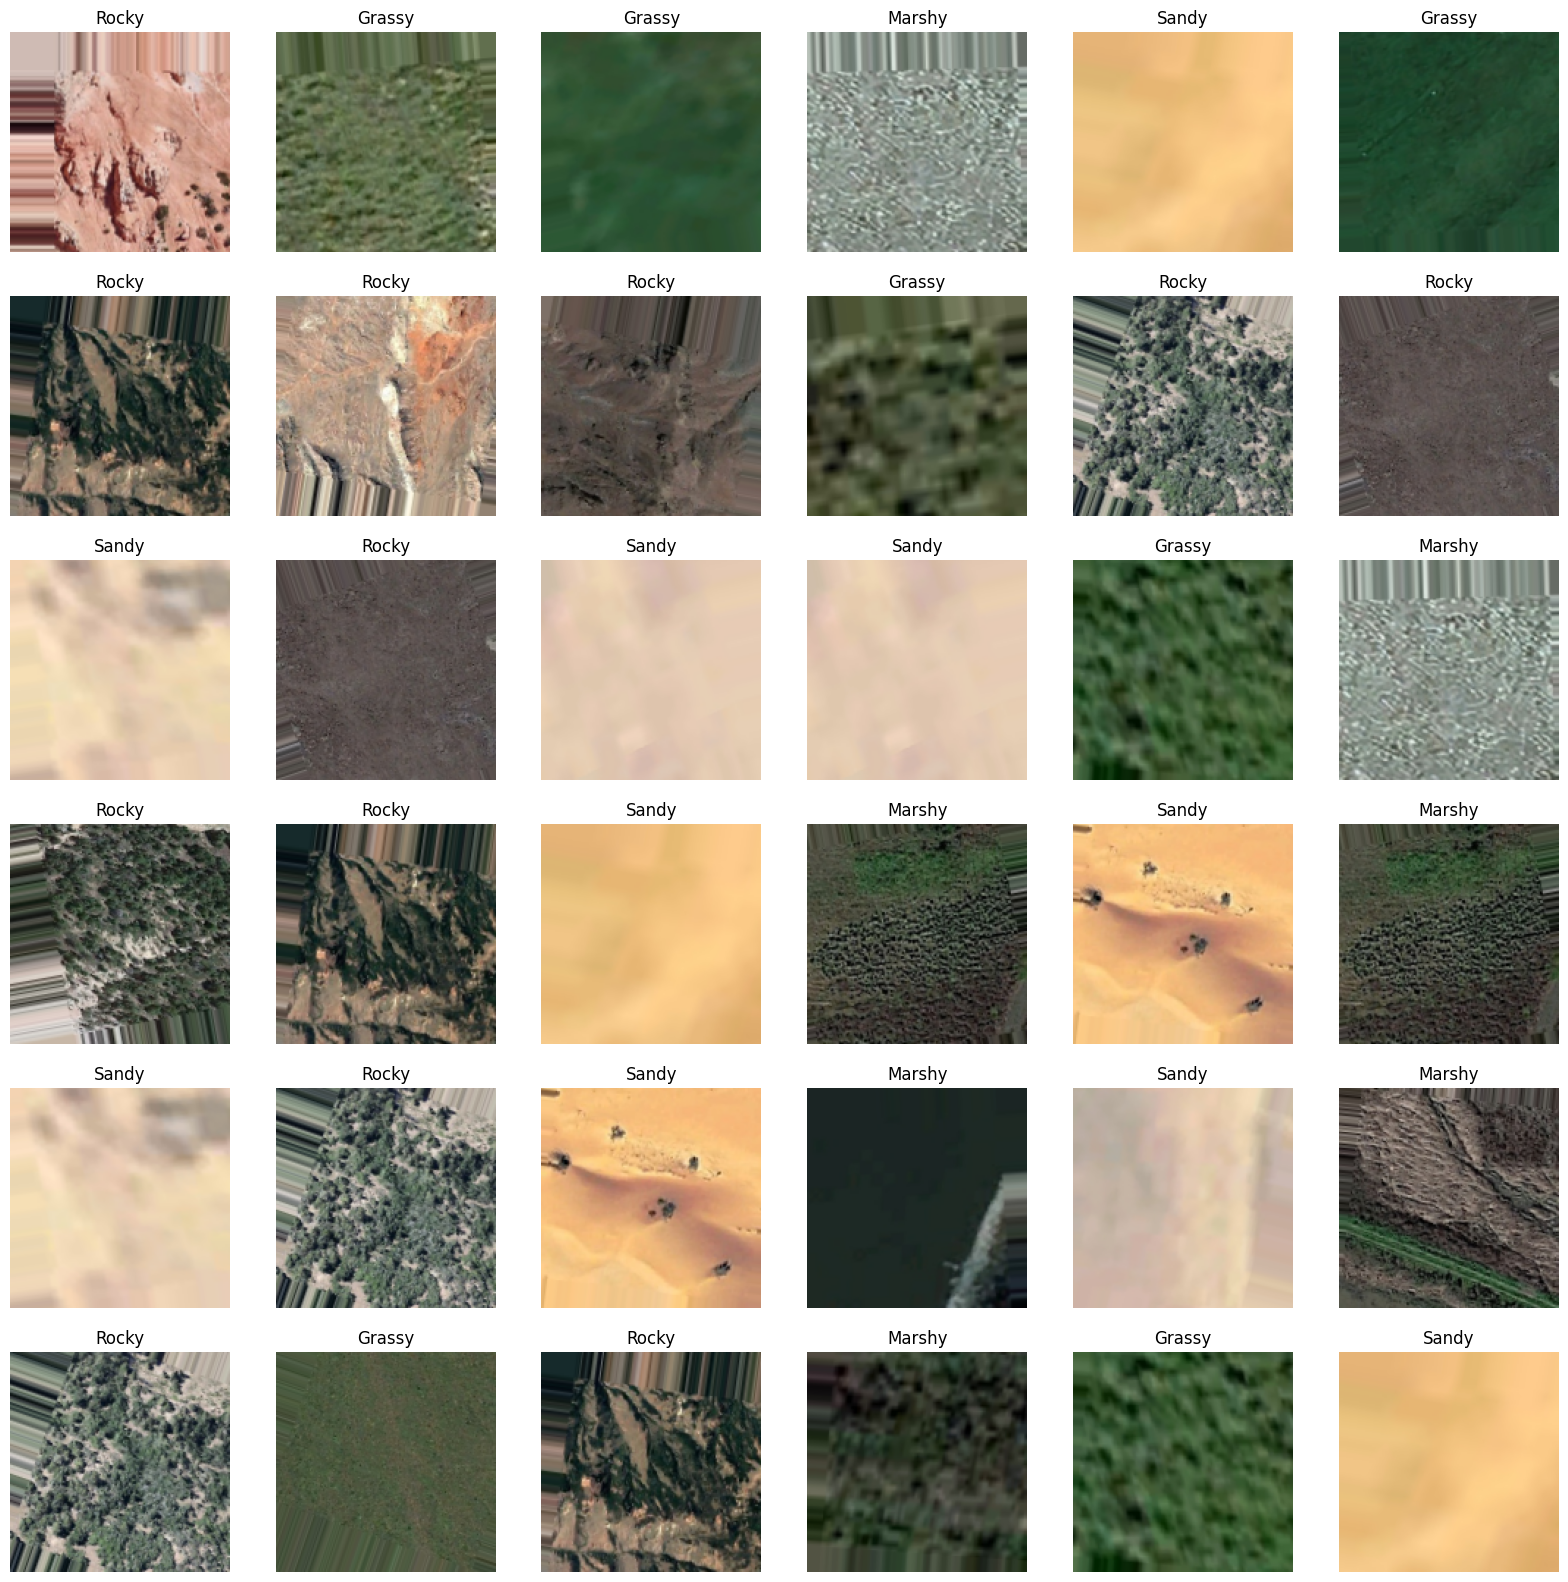

In [13]:
Show_Images(train_generator)

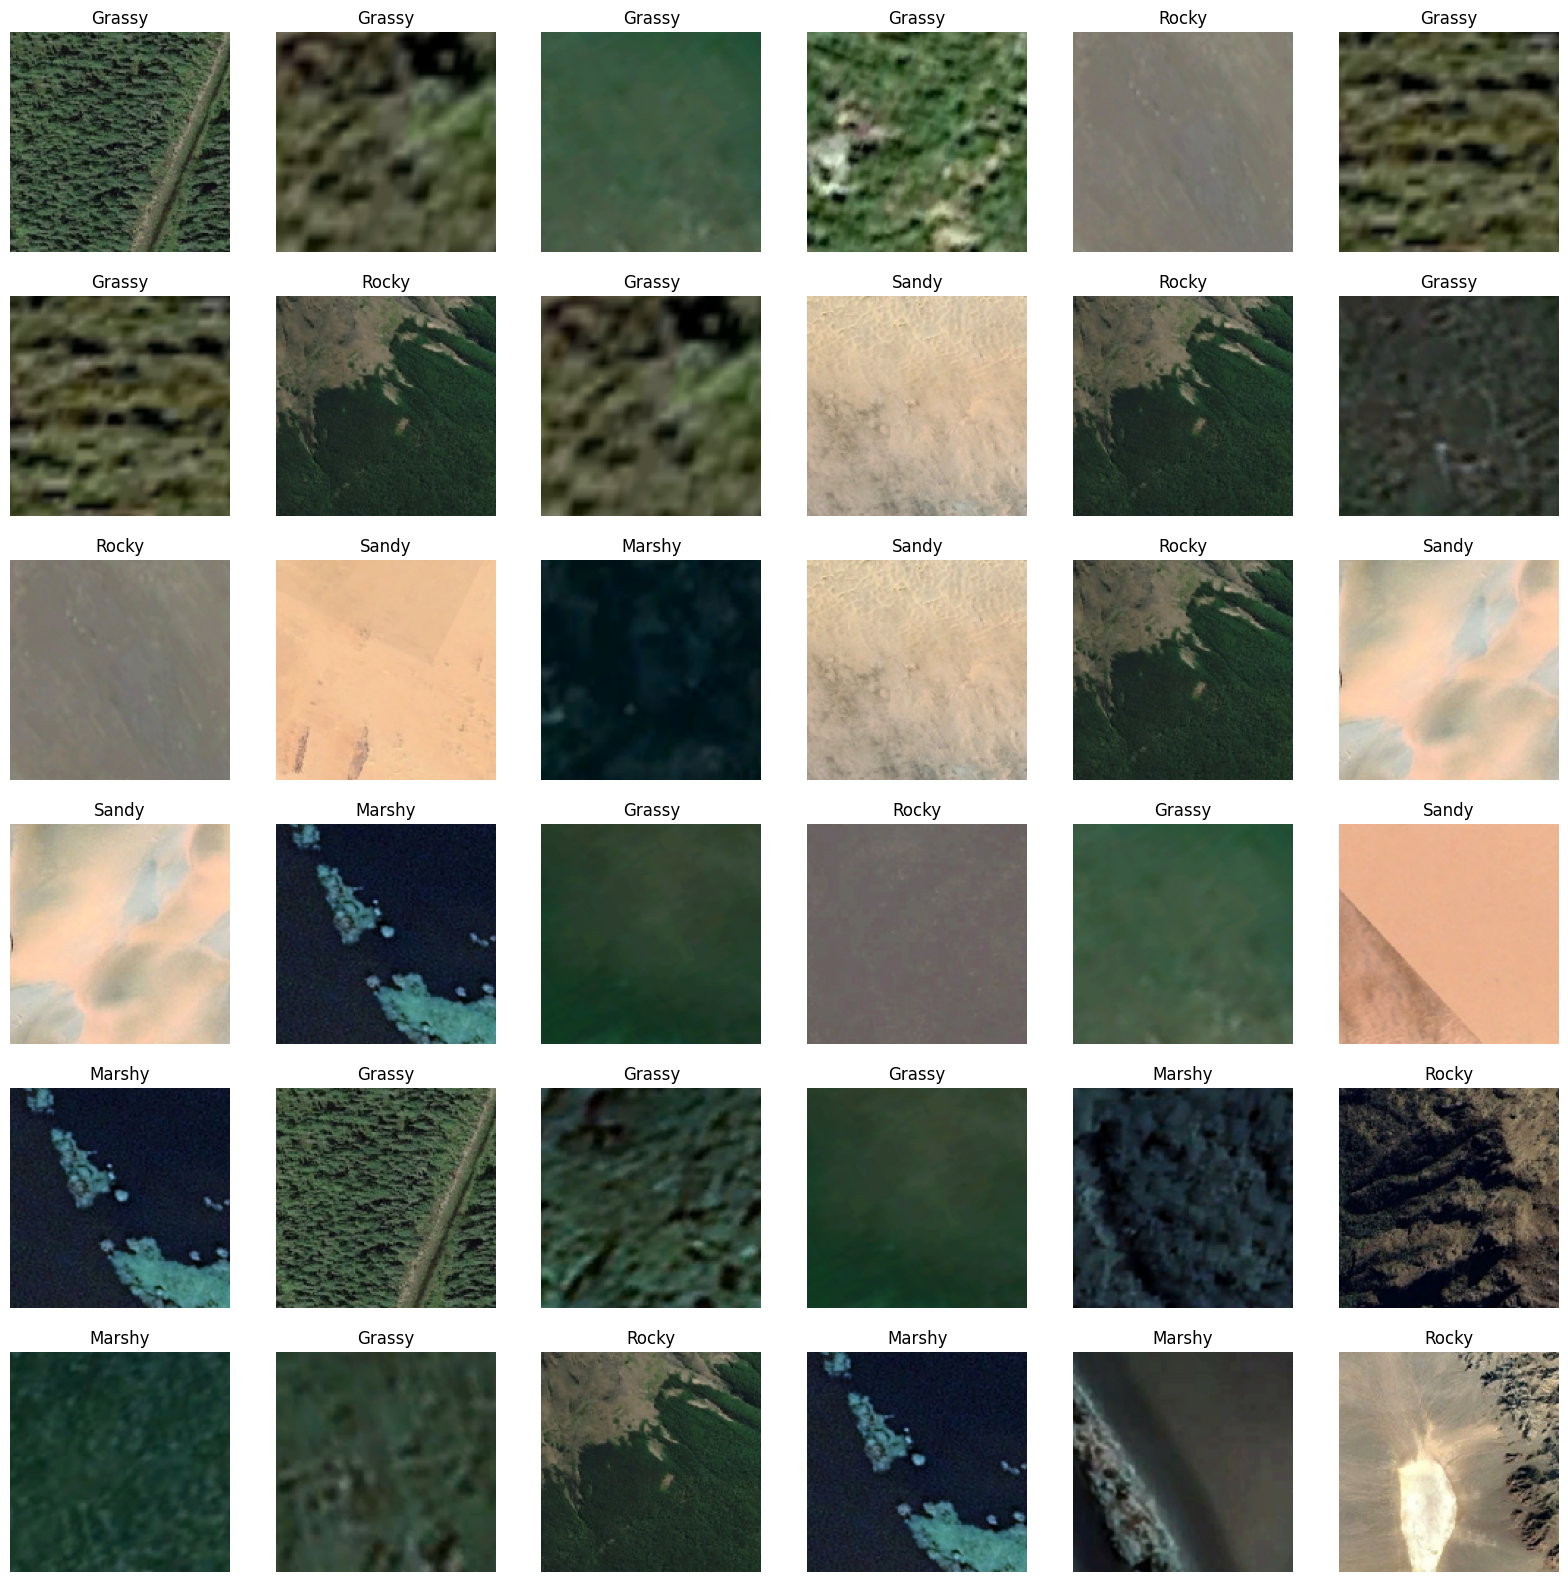

In [14]:
Show_Images(test_generator)

In [15]:
early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=5, # how many epochs to wait before stopping
    restore_best_weights=True,
)

In [16]:
learning_rate_reduce = ReduceLROnPlateau(
    monitor='val_acc',   # Metric to monitor for changes (usually validation accuracy)
    patience=5,          # Number of epochs with no improvement after which learning rate will be reduced
    verbose=1,           # Verbosity mode (0: silent, 1: update messages)
    factor=0.5,          # Factor by which the learning rate will be reduced (e.g., 0.5 means halving)
    min_lr=0.00001       # Lower bound for the learning rate (it won't go below this value)
)

In [17]:
base_model = tf.keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=(size_images, size_images, 3))

17225924/17225924 [==============================] - 0s 0us/step


In [18]:
for layer in base_model.layers:
    layer.trainable = False

In [19]:
from tensorflow.keras import layers
model = tf.keras.models.Sequential([
    base_model,
    
    layers.Flatten(),
    
    layers.Dense(256,activation='relu'),
    layers.Dense(128,activation='relu'),
    layers.Dense(64,activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(6,activation='softmax'),
])

In [20]:
# Define the parameters for the exponential decay schedule
initial_learning_rate = 0.1     # Initial learning rate
decay_steps = 1000              # Number of steps before decaying the learning rate
decay_rate = 0.5                # Rate at which the learning rate decays
staircase = True                # Whether to use staircase decay (integer division of step by decay_steps)

# Create the exponential decay schedule
def lr_schedule(epoch, lr):
    if staircase:
        return lr * decay_rate ** (epoch // decay_steps)
    else:
        return lr * decay_rate ** (epoch / decay_steps)

In [21]:
# Configure the learning rate reduction callback
learning_rate_reduce = ReduceLROnPlateau(
    monitor='val_acc',   # Metric to monitor for changes (usually validation accuracy)
    patience=5,          # Number of epochs with no improvement after which learning rate will be reduced
    verbose=1,           # Verbosity mode (0: silent, 1: update messages)
    factor=0.5,          # Factor by which the learning rate will be reduced (e.g., 0.5 means halving)
    min_lr=0.00001       # Lower bound for the learning rate (it won't go below this value)
)

In [22]:
from keras.callbacks import LearningRateScheduler

lr_callback = LearningRateScheduler(lr_schedule)
callback=[early_stopping , learning_rate_reduce , lr_callback]

In [23]:
model.compile(optimizer=keras.optimizers.Adam(lr=lr_callback),
             loss="categorical_crossentropy",
              metrics=['accuracy']
             )

In [24]:
from tensorflow.keras.layers import Dense

# Get the model architecture up to the last layer
model = tf.keras.Sequential(model.layers[:-1])

# Add a new output layer for 4 classes
new_output = Dense(4, activation='softmax')  # Assuming 4 classes
model.add(new_output)  # Add the new output layer

# Compile the model again after modifying the architecture
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [25]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=15,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    callbacks=[callback]
    
)

Epoch 1/15
986/986 [==============================] - 456s 454ms/step - loss: 0.4751 - accuracy: 0.8229 - val_loss: 0.2469 - val_accuracy: 0.9045 - lr: 0.0010
Epoch 2/15
986/986 [==============================] - 271s 275ms/step - loss: 0.2900 - accuracy: 0.8987 - val_loss: 0.1895 - val_accuracy: 0.9282 - lr: 0.0010
Epoch 3/15
986/986 [==============================] - 271s 275ms/step - loss: 0.2301 - accuracy: 0.9226 - val_loss: 0.2225 - val_accuracy: 0.9257 - lr: 0.0010
Epoch 4/15
986/986 [==============================] - 272s 276ms/step - loss: 0.1963 - accuracy: 0.9327 - val_loss: 0.1631 - val_accuracy: 0.9434 - lr: 0.0010
Epoch 5/15
986/986 [==============================] - 271s 275ms/step - loss: 0.1693 - accuracy: 0.9424 - val_loss: 0.1446 - val_accuracy: 0.9510 - lr: 0.0010
Epoch 6/15
986/986 [==============================] - 272s 276ms/step - loss: 0.1554 - accuracy: 0.9472 - val_loss: 0.1310 - val_accuracy: 0.9523 - lr: 0.0010
Epoch 7/15
986/986 [==========================

In [26]:
model.save('/kaggle/working/my_model.keras')

212/212 [==============================] - 24s 110ms/step
Classification Report:
              precision    recall  f1-score   support

      Grassy       0.26      0.27      0.27      1824
      Marshy       0.25      0.23      0.24      1657
       Rocky       0.25      0.26      0.26      1644
       Sandy       0.24      0.23      0.24      1644

    accuracy                           0.25      6769
   macro avg       0.25      0.25      0.25      6769
weighted avg       0.25      0.25      0.25      6769



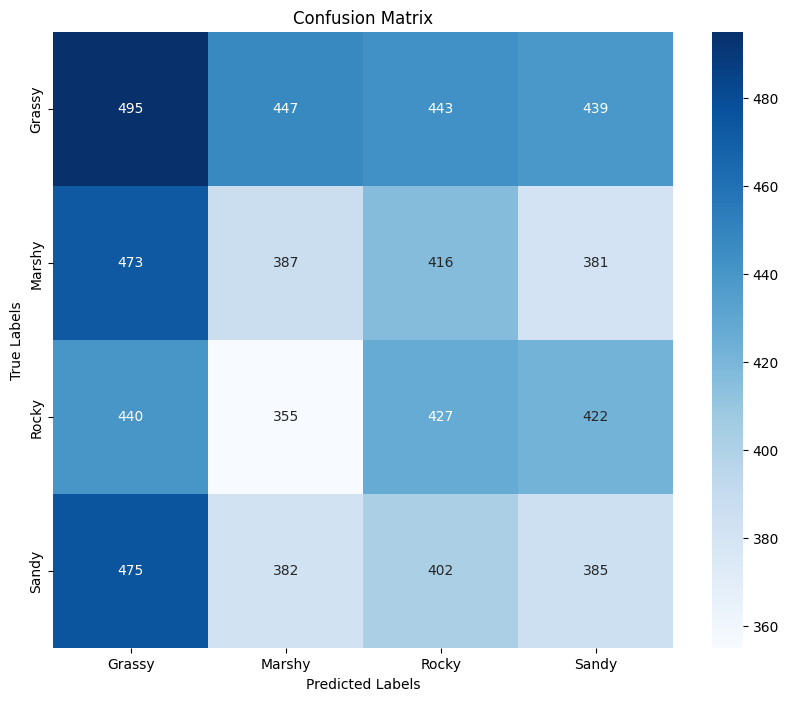

In [27]:
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load the saved model
loaded_model = load_model('/kaggle/working/my_model.keras')

# Assuming 'test_generator' is your test data generator
predictions = loaded_model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = test_generator.classes

# Classification Report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [28]:
score = model.evaluate(test_generator, verbose=False)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.10404908657073975
Test accuracy: 0.9623282551765442


<Figure size 640x480 with 0 Axes>

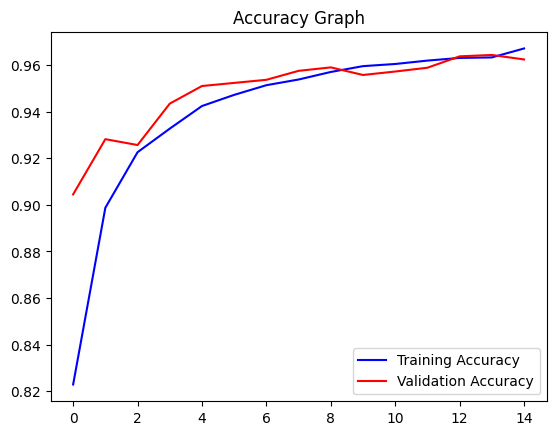

<Figure size 640x480 with 0 Axes>

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

In [30]:
base_model.summary

<bound method Model.summary of <keras.src.engine.functional.Functional object at 0x7fd5d842ea70>>